In [680]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import tools
from tools.cbook import pickle2Obj, interp_z, compute_thetae
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

teclevs = list(300. + 5*np.arange(70))

bclevs = list(-0.4+ 0.02*np.arange(100))
pclevs = list(-15.0 + np.arange(31))

dclevs = list(-20.0 + np.arange(41))

zlevels = 10.0 + 100.*np.arange(200)

def label_panels(axs, panel_labels, fontsize=14, adjust_loc=None):

    from operator import add

    base_loc = [0.025, 0.975]

    if adjust_loc:
        loc = list(map(add, base_loc, adjust_loc)) 
    else:
        loc = base_loc

    for i, ax in enumerate(axs.flatten()):
    # Add the panel label
        ax.text(*loc, panel_labels[i], transform=ax.transAxes, fontsize=fontsize, fontweight='medium', va='top', ha='left')

    return axs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


scipy.interpolate.Akima1DInterpolator
scipy.interpolate.BPoly
scipy.interpolate.BSpline
scipy.interpolate.BarycentricInterpolator
scipy.interpolate.BivariateSpline
scipy.interpolate.CloughTocher2DInterpolator
scipy.interpolate.CubicHermiteSpline
scipy.interpolate.CubicSpline
scipy.interpolate.InterpolatedUnivariateSpline
scipy.interpolate.KroghInterpolator
scipy.interpolate.LSQBivariateSpline
scipy.interpolate.LSQSphereBivariateSpline
scipy.interpolate.LSQUnivariateSpline
scipy.interpolate.LinearNDInterpolator
scipy.interpolate.NdBSpline
scipy.interpolate.NdPPoly
scipy.interpolate.NearestNDInterpolator
scipy.interpolate.PPoly
scipy.interpolate.PchipInterpolator
scipy.interpolate.RBFInterpolator
scipy.interpolate.Rbf
scipy.interpolate.RectBivariateSpline
scipy.interpolate.RectSphereBivariateSpline
scipy.interpolate.RegularGridInterpolator
scipy.interpolate.SmoothBivariateSpline
scipy.interpolate.SmoothSphereBivariateSpline
scipy.interpolate.UnivariateSpline
scipy.interpolate.__all__
sci

In [724]:
paths = {}
paths['cm1']  = '/work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13'
paths['solo'] = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV13'
#paths['solo-div'] = '/work/wicker/climate_runs/FV3_Solo/bubble/div/3km/QV16'

models = {}
for key in paths:
    print("\n Reading: ",key)
    if key[0:3] == 'cm1':
        models[key] = ( read_cm1_fields(paths[key], vars = ['w', 'pert_p', 'dwdt', 'rwqv', 'rw'], zinterp=zlevels, ret_beta=True, ret_ds=False) )
    if key[0:4] == 'solo':
        models[key] = ( read_solo_fields(paths[key], vars = ['w', 'pert_p', 'dwdt', 'rwqv', 'rw'], zinterp=zlevels, ret_beta=True, ret_ds=False) )


 Reading:  cm1
------------------------------------------------------------------------------------------------------------------------

 Now reading... /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13/cm1out.nc
 -->Could not find buoyant pressure gradient decomp


 Reading BETA from /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13/w_b_accel.nc

 Reading density from /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13/total_den.nc

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13/cm1out.nc
------------------------------------------------------------------------------------------------------------------------

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV13/cm1out.nc 

 Interpolation could not be done on rho_p, as shape is (61, 200, 64, 64)
 Interpolation could not be done on beta, as shape is (61, 200, 64, 64)
 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm

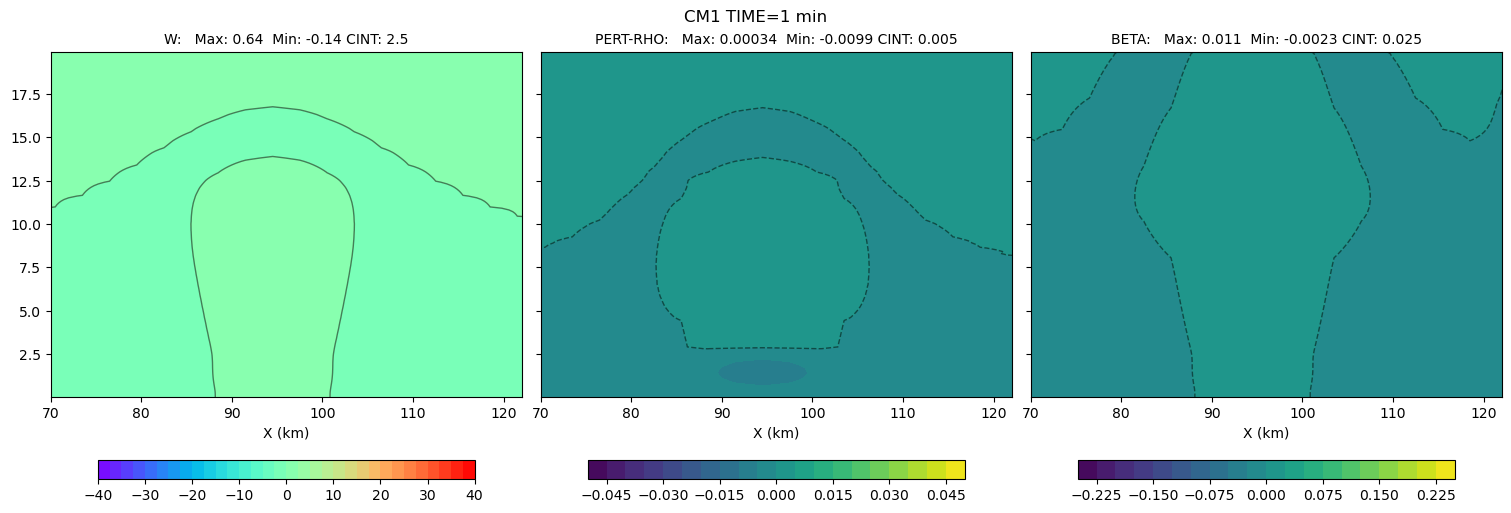

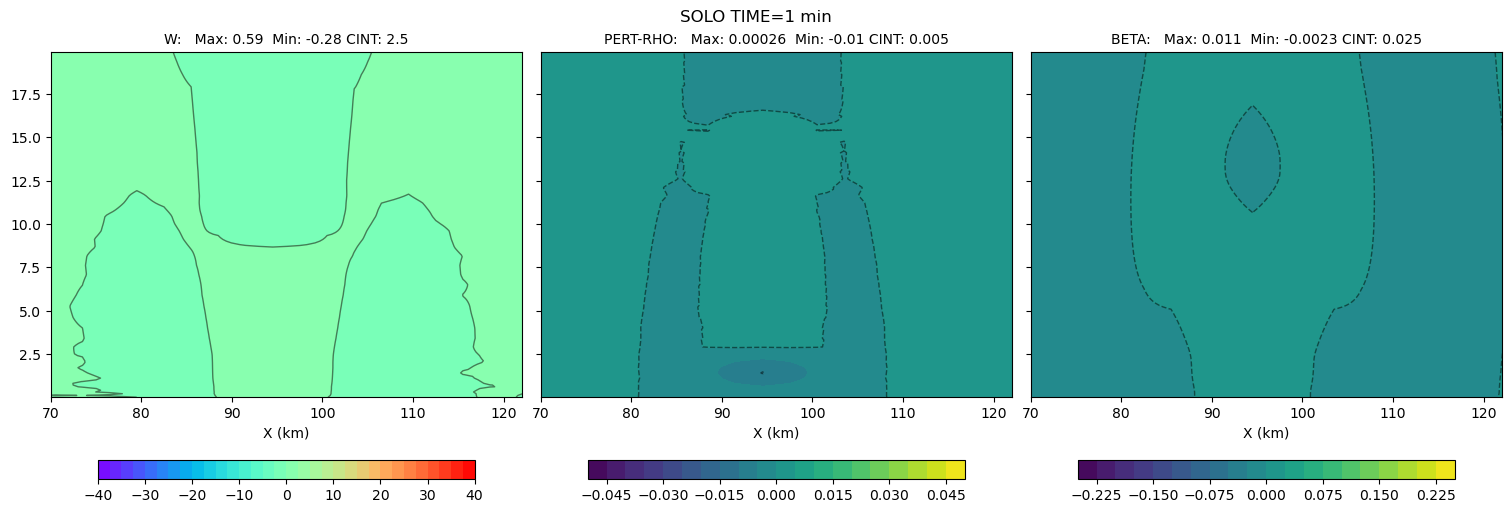

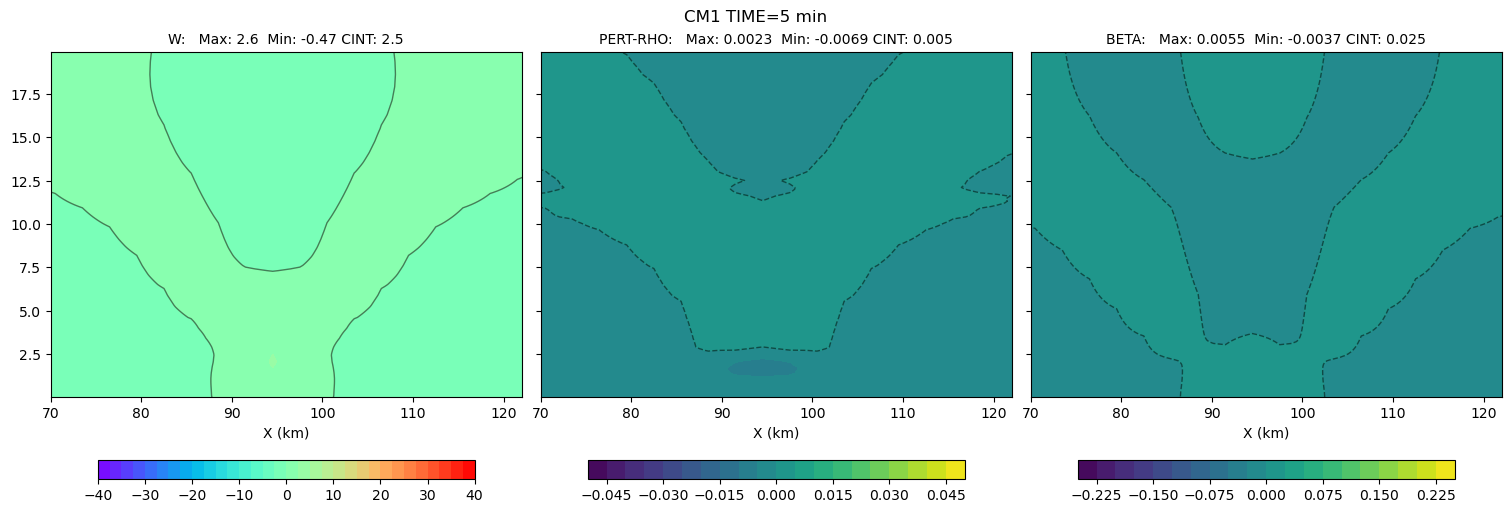

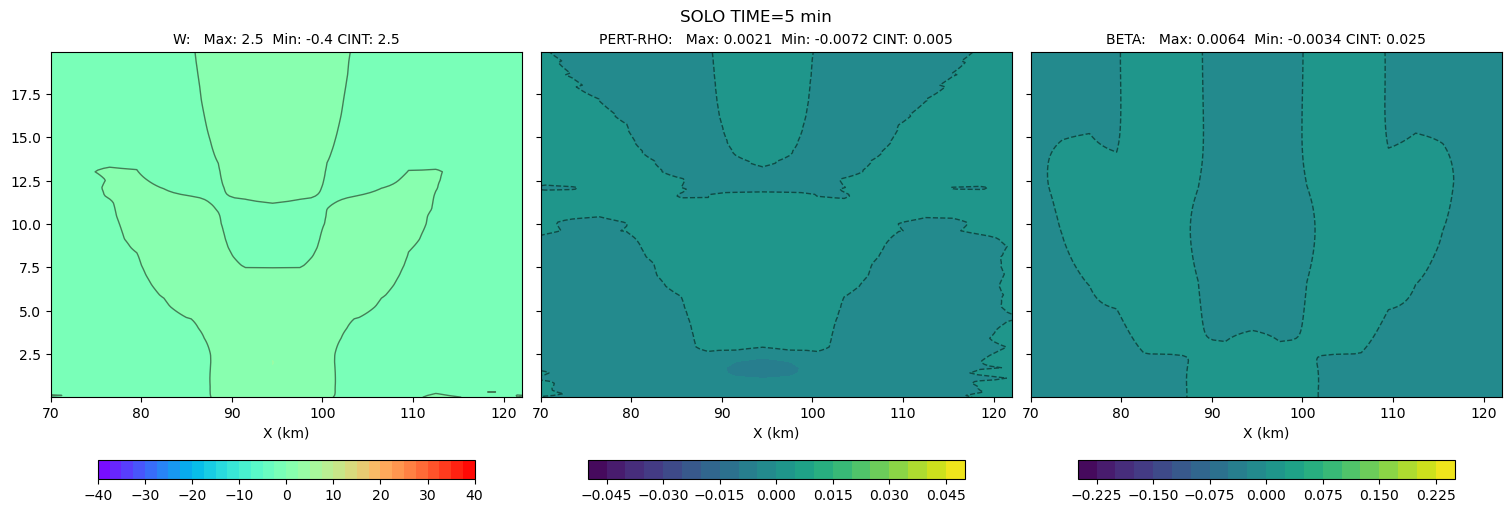

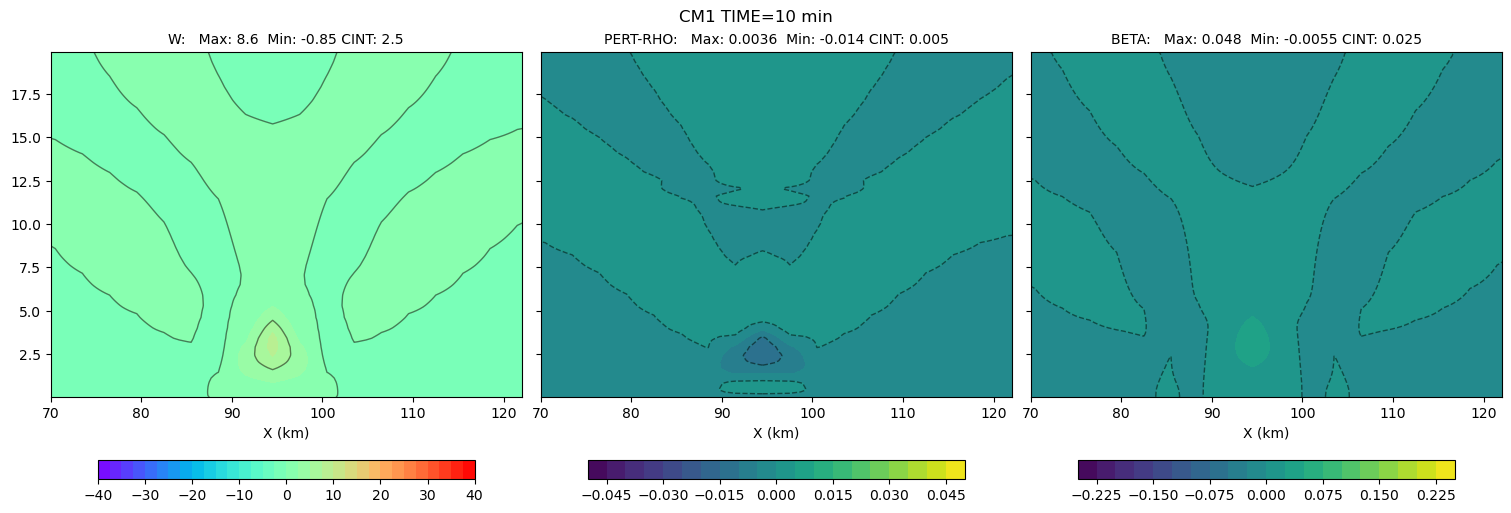

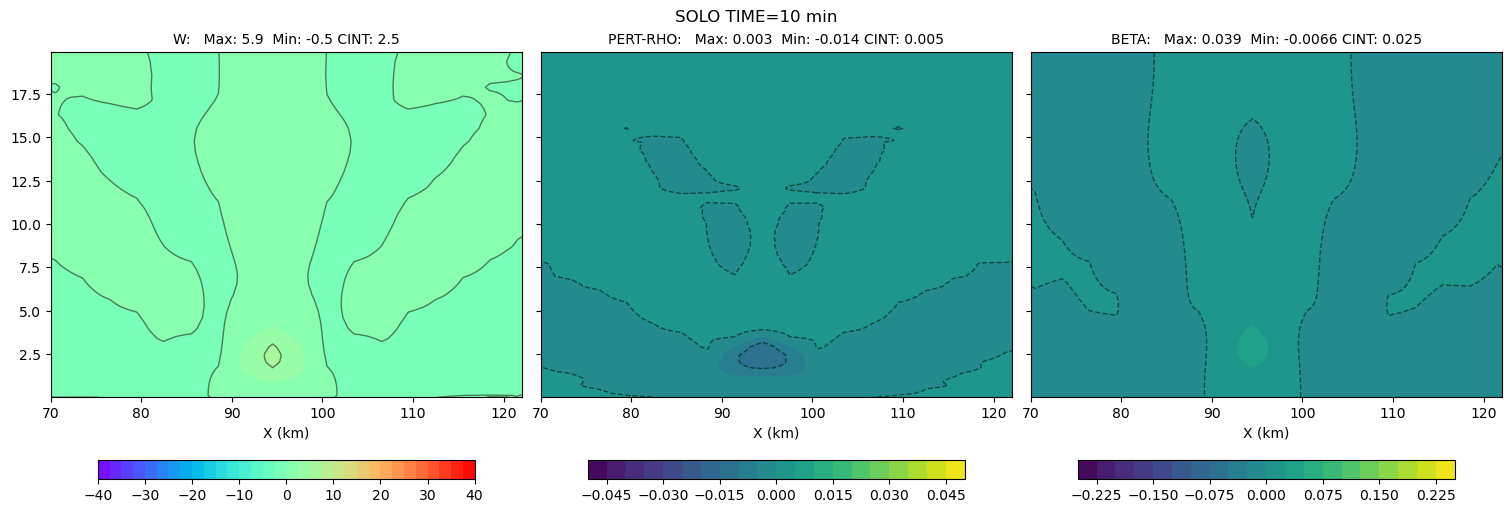

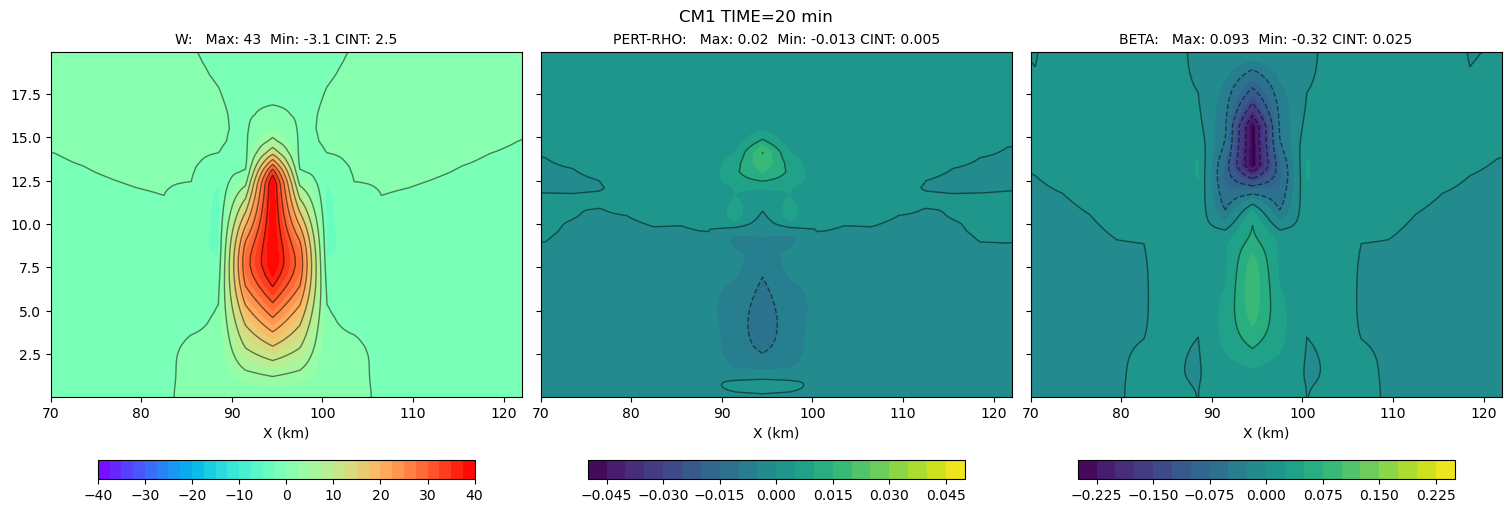

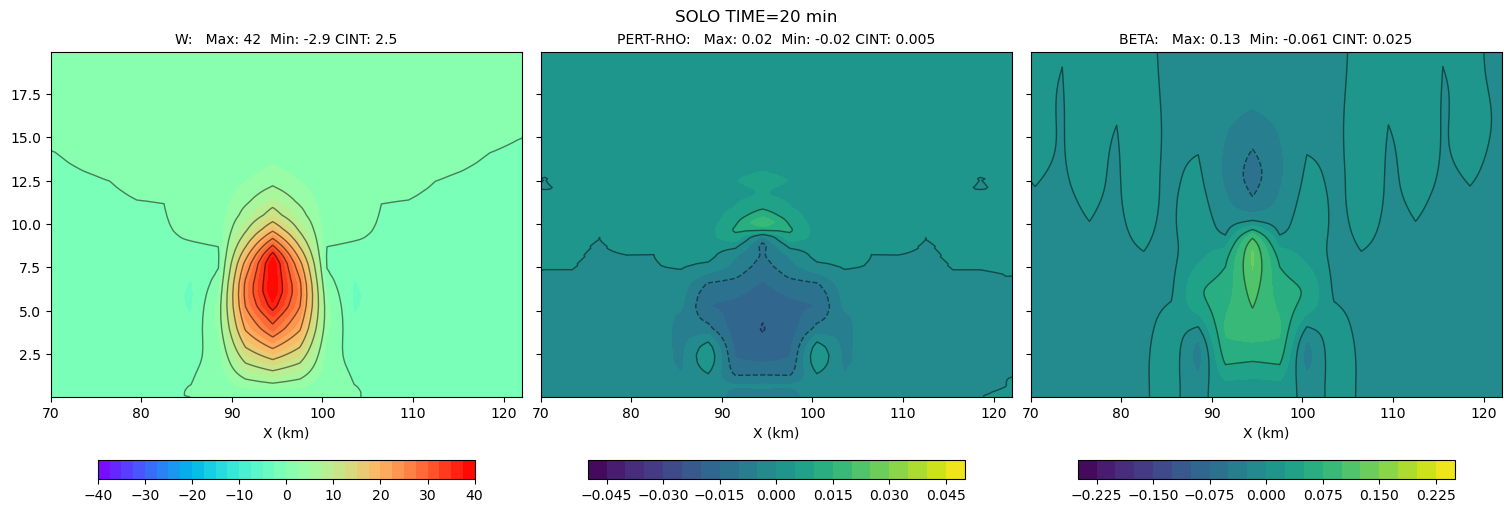

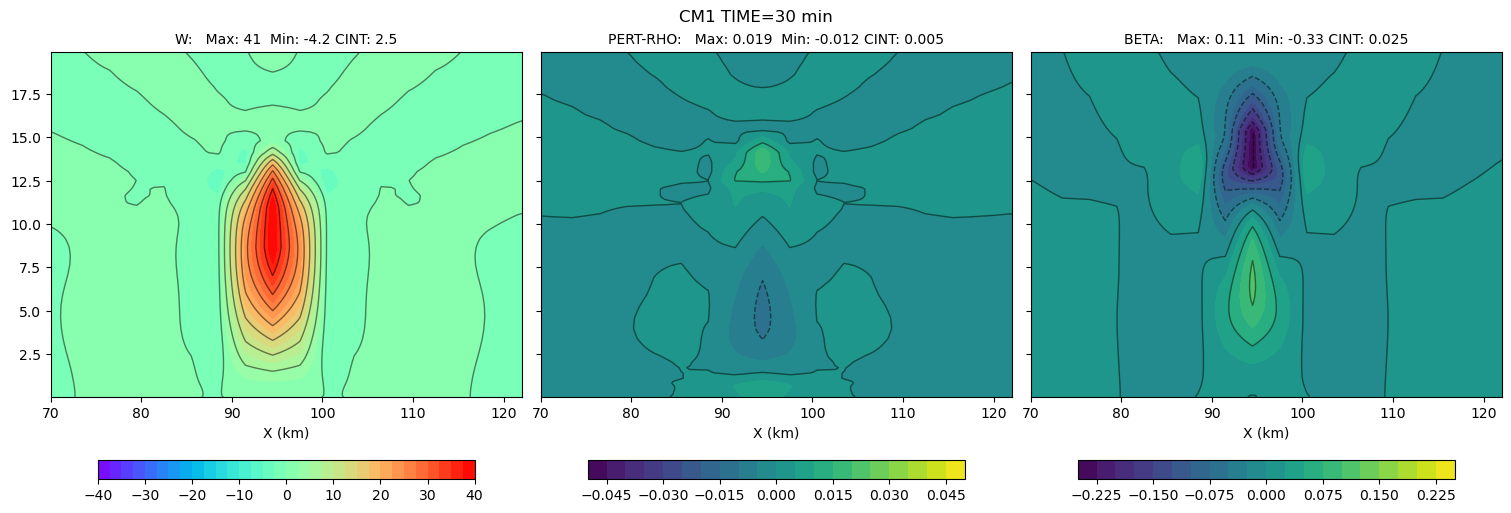

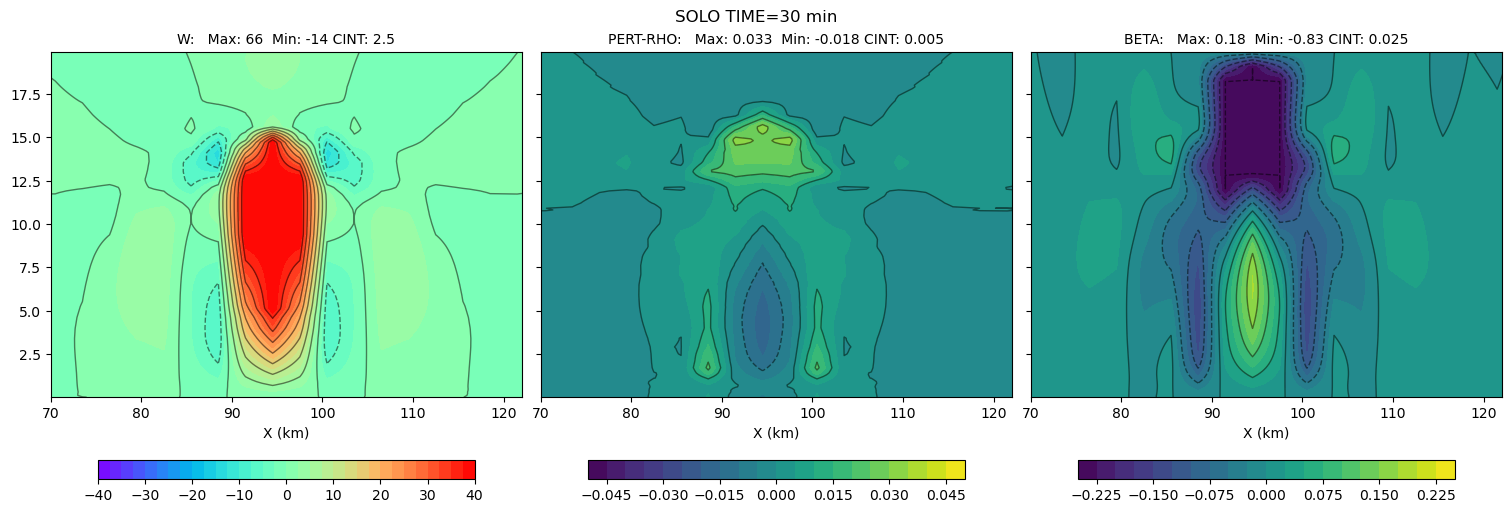

In [213]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

nx2 = (xc.shape[0]//2) - 1
ny2 = (yc.shape[0]//2) - 1

clevs = list(-3. + 0.25*np.arange(25))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

ny2 = (xc.shape[0]//2) - 1

wcint   = [-40.,40.,2.5]
rcint   = [-0.05, 0.05, 0.005]
bcint   = [-0.25, 0.25, 0.025]
c_focus = None

for tlevel in [1, 5, 10, 20, 30]:

    fields = []
    fields.append(container( cm1['w'][tlevel,  :,:,ny2],     yc, zlevels/1000.,    limit_fld=True, c_focus=c_focus,    cint=wcint, cmap=plt.cm.rainbow))
    fields.append(container( cm1['rho_p'][tlevel,  :,:,ny2], yc, zlevels/1000.,                  cint=rcint, cmap=plt.cm.viridis))
    fields.append(container( cm1['beta'][tlevel,  :,:,ny2],  yc, zlevels/1000.,                  cint=bcint, cmap=plt.cm.viridis))
    plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"CM1 TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.], sharey=True);

    fields = []
    fields.append(container(solo['w'][tlevel-1,:,:,ny2], yc, zlevels/1000.,         limit_fld=True,  cint=wcint, cmap=plt.cm.rainbow))
    fields.append(container(solo['rho_p'][tlevel-1,:,:,ny2], yc, zlevels/1000.,                  cint=rcint, cmap=plt.cm.viridis))
    fields.append(container(solo['beta'][tlevel-1,:,:,ny2], yc, zlevels/1000.,                   cint=bcint, cmap=plt.cm.viridis)) 
    plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"SOLO TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.],
                     sharey=True);

    # fields = []
    # fields.append(container(div['w'][tlevel-1,:,:,ny2], yc, zlevels/1000.,     cint=wcint, cmap=plt.cm.rainbow))
    # fields.append(container(div['rho_p'][tlevel-1,:,:,ny2], yc, zlevels/1000., cint=rcint, cmap=plt.cm.viridis))
    # fields.append(container(div['beta'][tlevel-1,:,:,ny2], yc, zlevels/1000.,  cint=bcint, cmap=plt.cm.viridis))
    
    # plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"S-DIV TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.],
    #                  sharey=True);


#plt.savefig(f"XZ_3km.png")

    # klevel = 10
    
    # fields = []
    # fields.append(container( cm1['beta'][tlevel,   klevel, :, :], yc, xc))
    # fields.append(container(solo['beta'][tlevel-1, klevel, :, :], yc, xc))
    # plot_contour_row(fields, ptitle=['CM1', 'SOLO'], suptitle=f"BUBBLE TIME={tlevel} min", xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.01);

# plt.savefig(f"Initial_Condition_XY_K10_3km.png")

# fields = []
# fields.append(container(cm1['pert_th'][0,:,96:160,23]-solo['theta_IC'][:,96:160,23], xc[96:160], zlevels/1000.))
# plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Z (km)',  cmap=plt.cm.rainbow, cint=0.001)


# fields = []
# fields.append(container(cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64], xc[96:160], yc[0:64]))
# plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.001);

# print((cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64]).min())

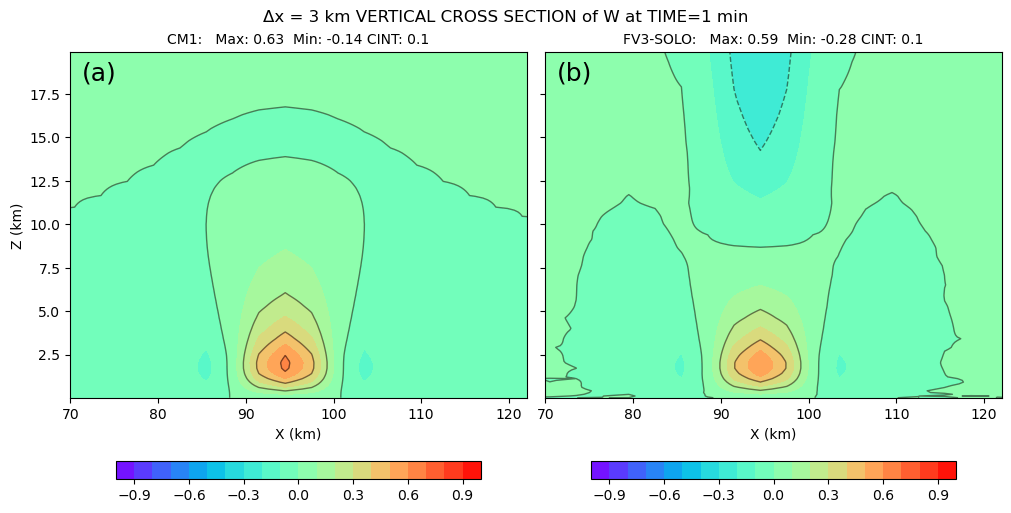

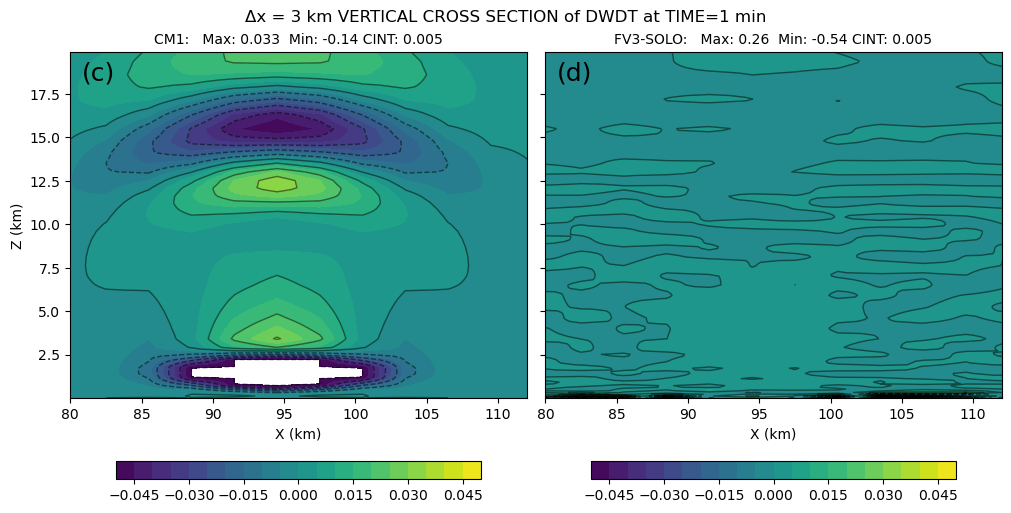

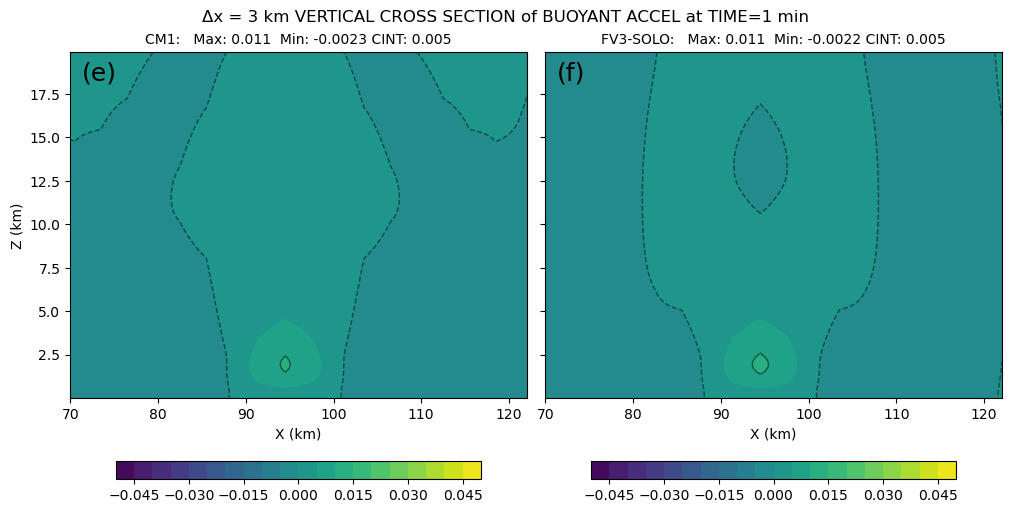

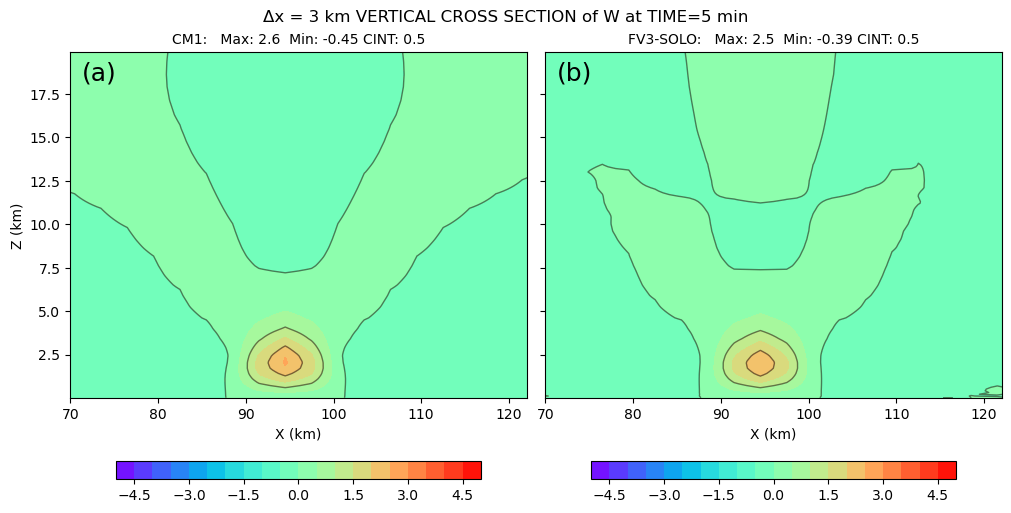

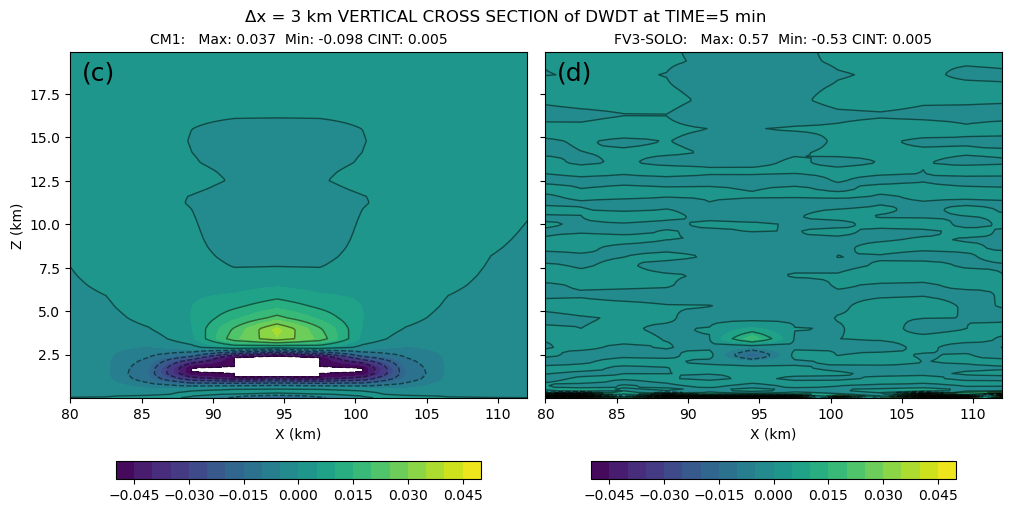

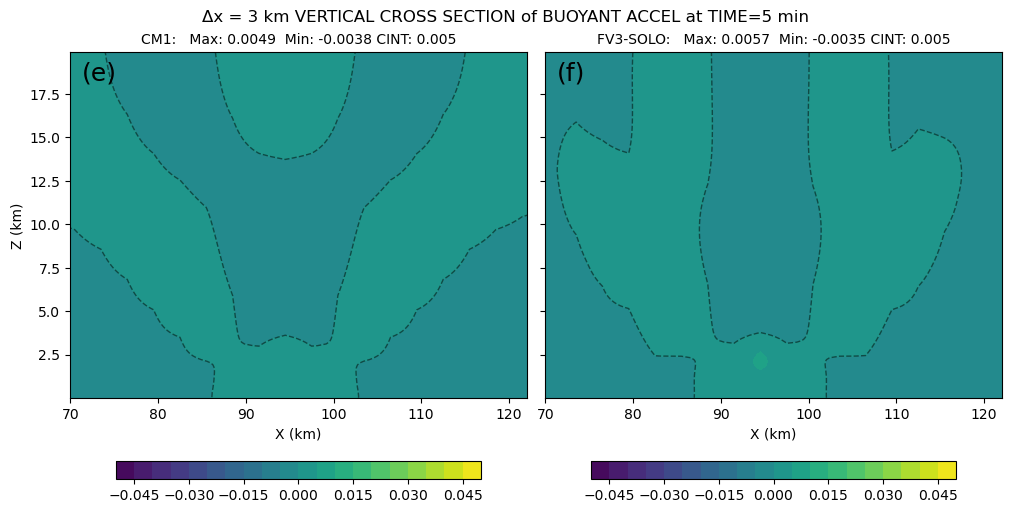

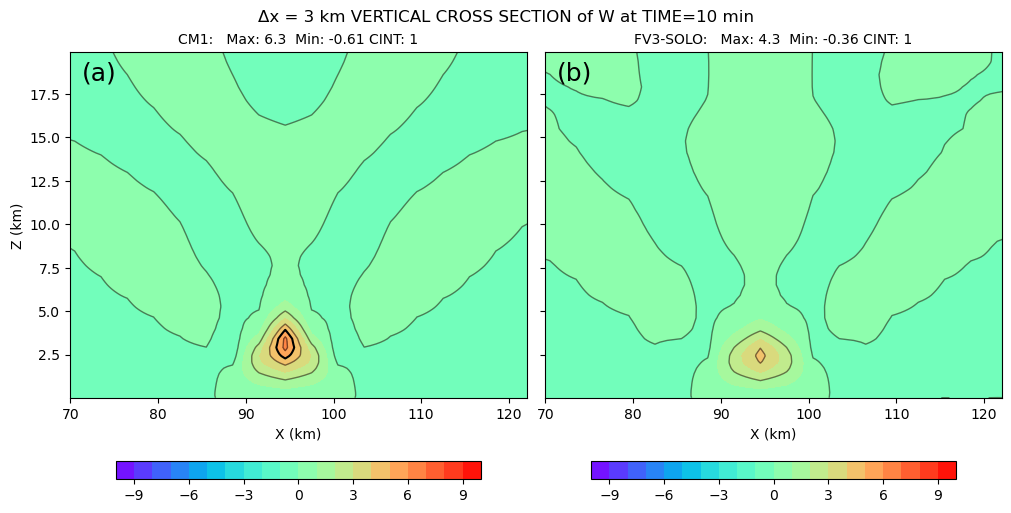

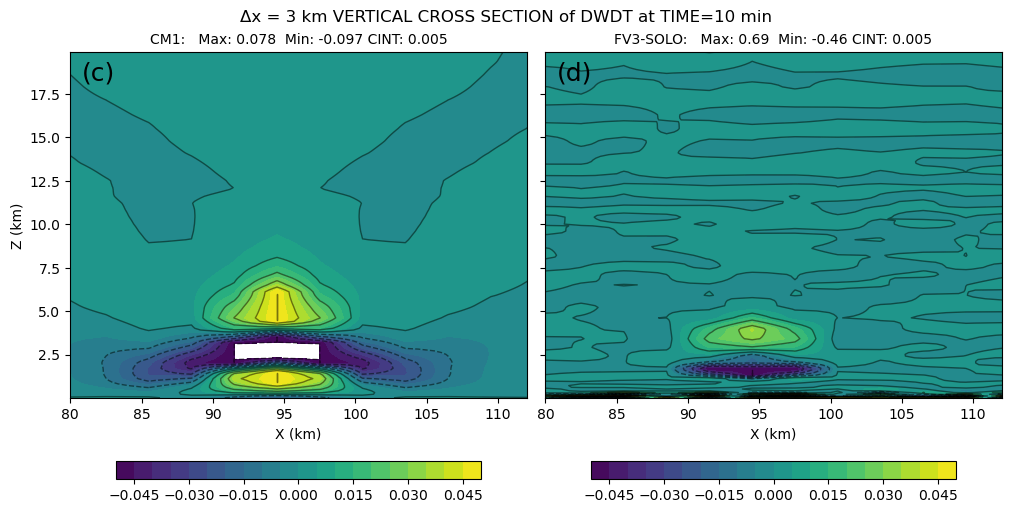

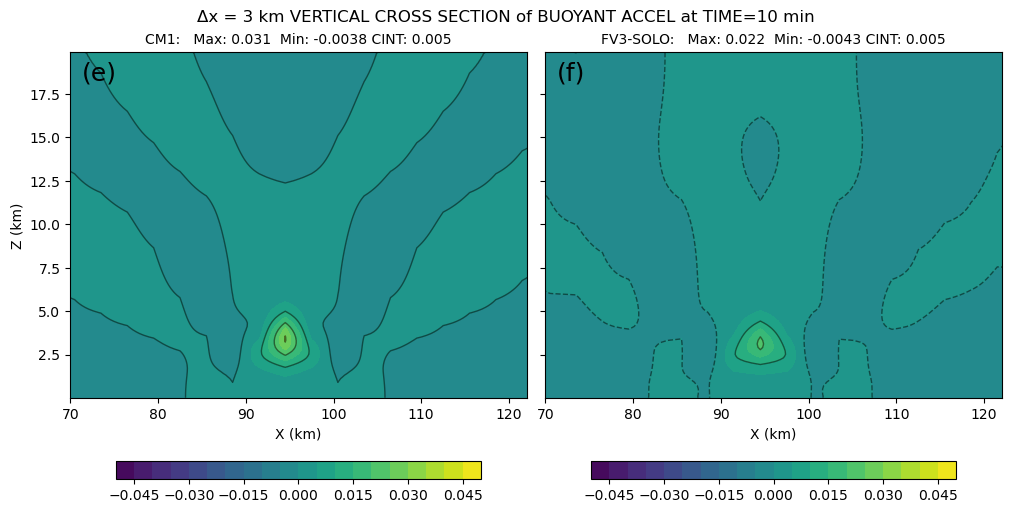

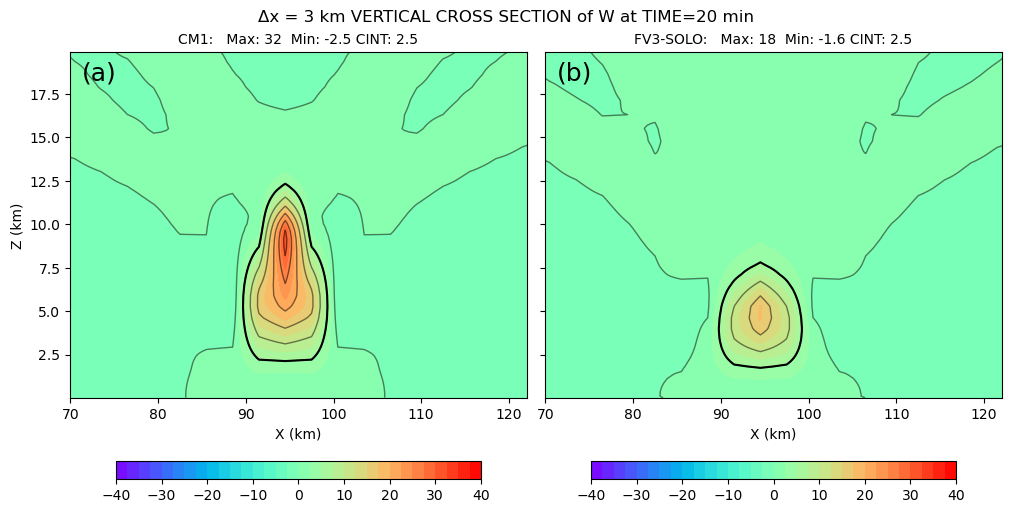

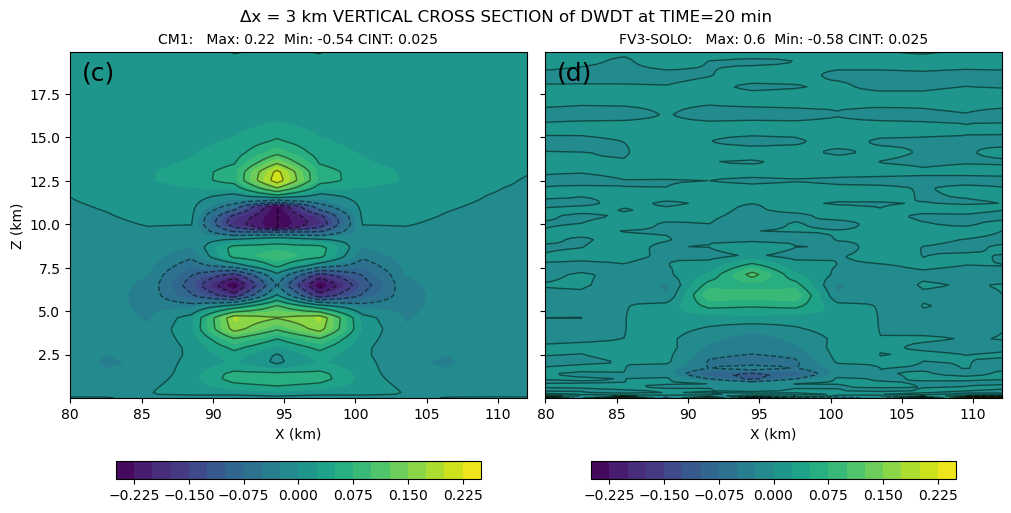

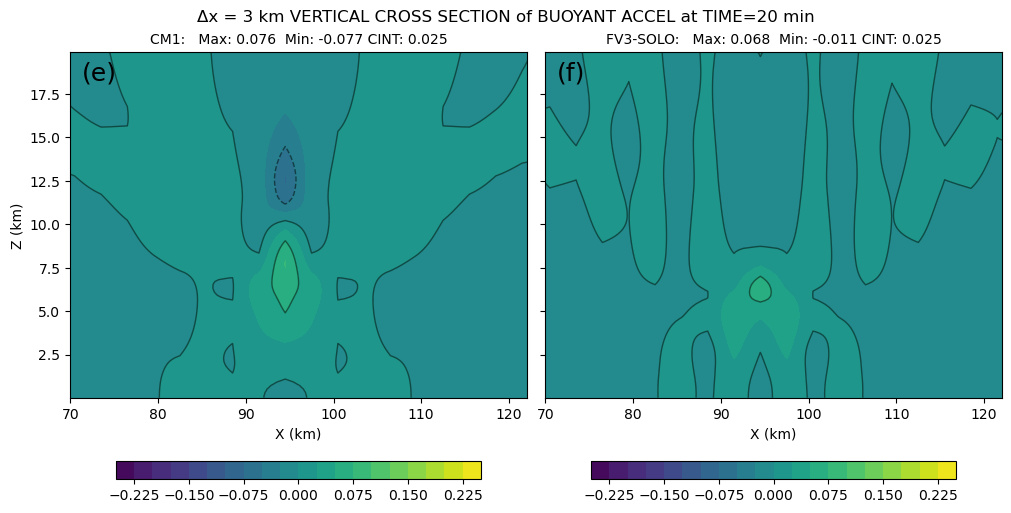

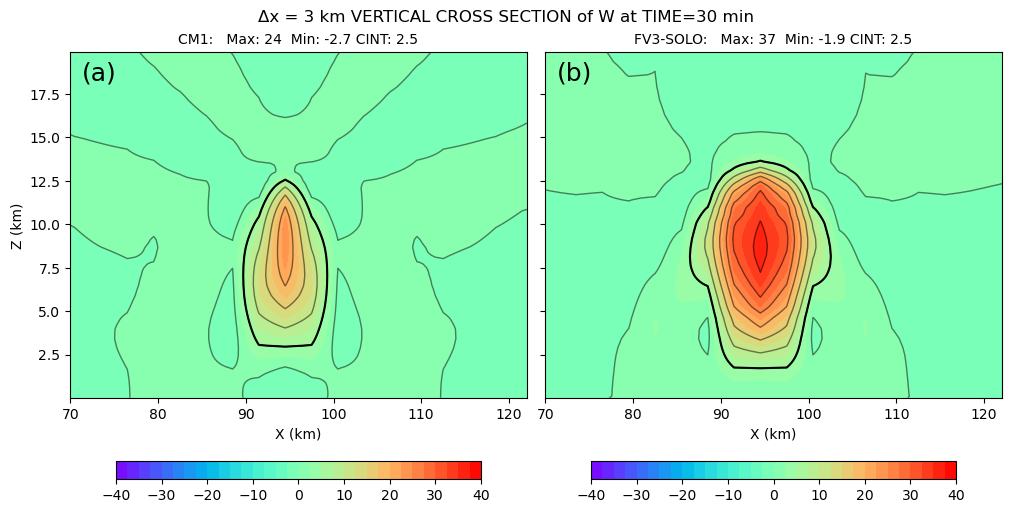

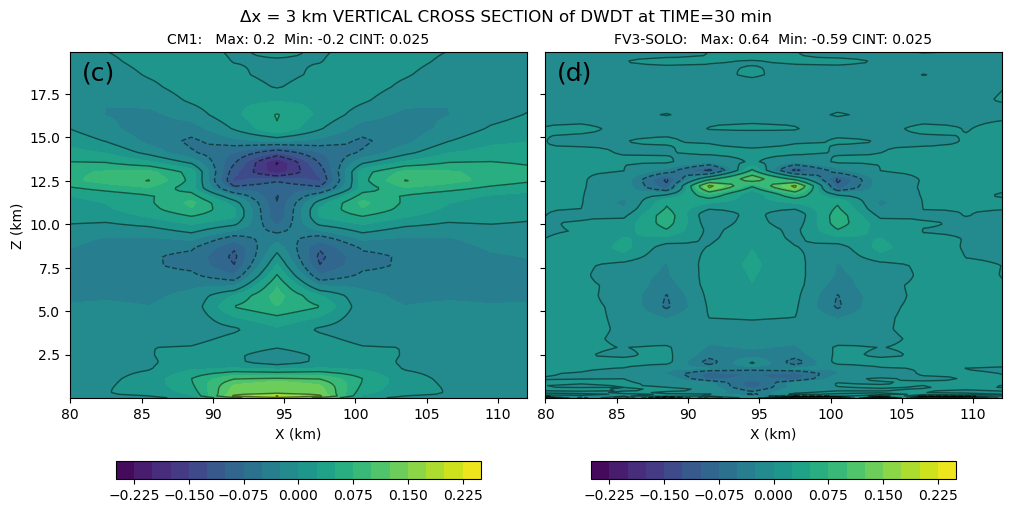

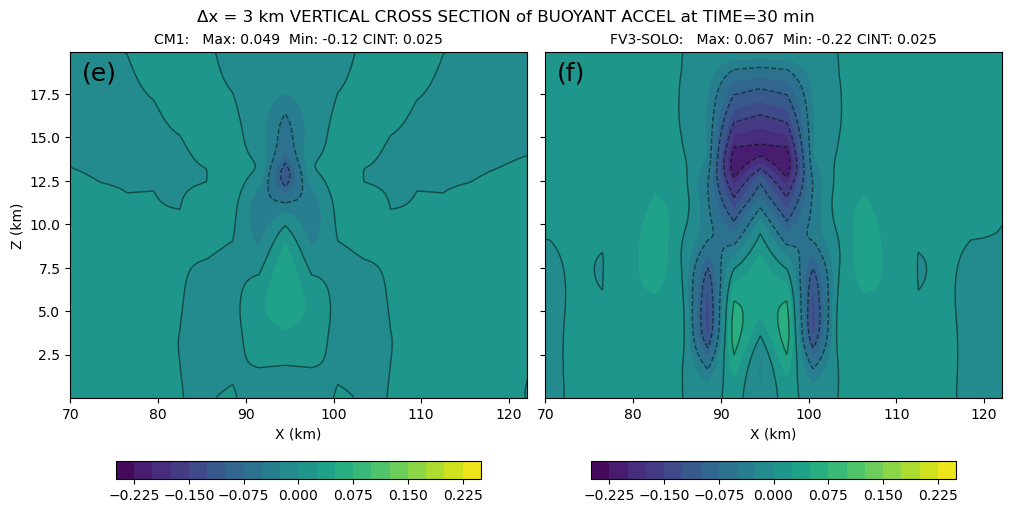

In [727]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

nx2 = (xc.shape[0]//2) - 1
ny2 = (yc.shape[0]//2) - 1

clevs = list(-3. + 0.25*np.arange(25))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

ny2 = (xc.shape[0]//2) - 1

wcint   = [-40.,40.,2.5]
rcint   = [-0.05, 0.05, 0.005]
bcint   = [-0.25, 0.25, 0.025]
c_focus = None

for tlevel in [1, 5, 10, 20, 30]:

    match tlevel:
        case 1:
            wcint   = [-1.,1.,0.1]
            bcint   = [-0.05, 0.05, 0.005]
        case 5:
            wcint   = [-5.,5.,0.5]
            bcint   = [-0.05, 0.05, 0.005]
        case 10:
            wcint   = [-10.,10.,1.0]
            bcint   =  [-0.05, 0.05, 0.005]
        case _:
            wcint   = [-40.,40.,2.5]
            bcint   = [-0.25, 0.25, 0.025]

    pclevs = list(-50.0 + 5.0*np.arange(21))
    
    fields = []
    fields.append(container( cm1['w'][tlevel,  :,:,ny2],     yc, zlevels/1000.,   limit_fld=True, cint=wcint, cmap=plt.cm.rainbow))
    fields.append(container(solo['w'][tlevel-1,:,:,ny2],     yc, zlevels/1000.,   limit_fld=True, cint=wcint, cmap=plt.cm.rainbow))
    fig, axes = plot_contour_row(fields, ptitle=['CM1', 'FV3-SOLO'], suptitle=f"\u0394x = 3 km VERTICAL CROSS SECTION of W at TIME={tlevel} min", 
                                 xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.],sharey=True);
    
    axes[0].set_ylabel('Z (km)', fontsize=10);
    axes[0].contour(yc, zlevels/1000., cm1['w'][tlevel,  :,:,ny2], levels=[5.0,],  colors=['k',], linewidth=[4.0,] )
    axes[1].contour(yc, zlevels/1000., solo['w'][tlevel-1,:,:,ny2], levels=[5.0,], colors=['k',], linewidth=[4.0,] )
    label_panels(axes, ['(a)', '(b)'], fontsize=18)

    plt.savefig(f"./Figures/Bubble_XZ_W_3km_TIME_{tlevel}_min.pdf")

    fields = []
    fields.append(container( cm1['dwdt'][tlevel,  :,:,ny2]*2, yc, zlevels/1000.,                   cint=bcint, cmap=plt.cm.viridis))
    fields.append(container(solo['dwdt'][tlevel-1,:,:,ny2]/5, yc, zlevels/1000.,                   cint=bcint, cmap=plt.cm.viridis)) 

    fig, axes = plot_contour_row(fields, ptitle=['CM1', 'FV3-SOLO'], suptitle=f"\u0394x = 3 km VERTICAL CROSS SECTION of DWDT at TIME={tlevel} min", 
                                 xlabel='X (km)', ylabel='Z (km)', xlim=[80.,112.], sharey=True);

    axes[0].set_ylabel('Z (km)', fontsize=10);

    label_panels(axes, ['(c)', '(d)'], fontsize=18)

    plt.savefig(f"./Figures/Bubble_XZ_PertP_3km_TIME_{tlevel}_min.pdf")

    fields = []
    fields.append(container( cm1['beta'][tlevel,  :,:,ny2], yc, zlevels/1000.,                  cint=bcint, cmap=plt.cm.viridis))
    fields.append(container(solo['beta'][tlevel-1,:,:,ny2], yc, zlevels/1000.,                   cint=bcint, cmap=plt.cm.viridis)) 

    fig, axes = plot_contour_row(fields, ptitle=['CM1', 'FV3-SOLO'], suptitle=f"\u0394x = 3 km VERTICAL CROSS SECTION of BUOYANT ACCEL at TIME={tlevel} min", 
                                 xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.], sharey=True);

    axes[0].set_ylabel('Z (km)', fontsize=10);

    label_panels(axes, ['(e)', '(f)'], fontsize=18)

    plt.savefig(f"./Figures/Bubble_XZ_BuoyAccel_3km_TIME_{tlevel}_min.pdf")

In [298]:
from spectra import py_spectra

[0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25    0.28125
 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125 0.5625
 0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125  0.84375
 0.875   0.90625 0.9375  0.96875]


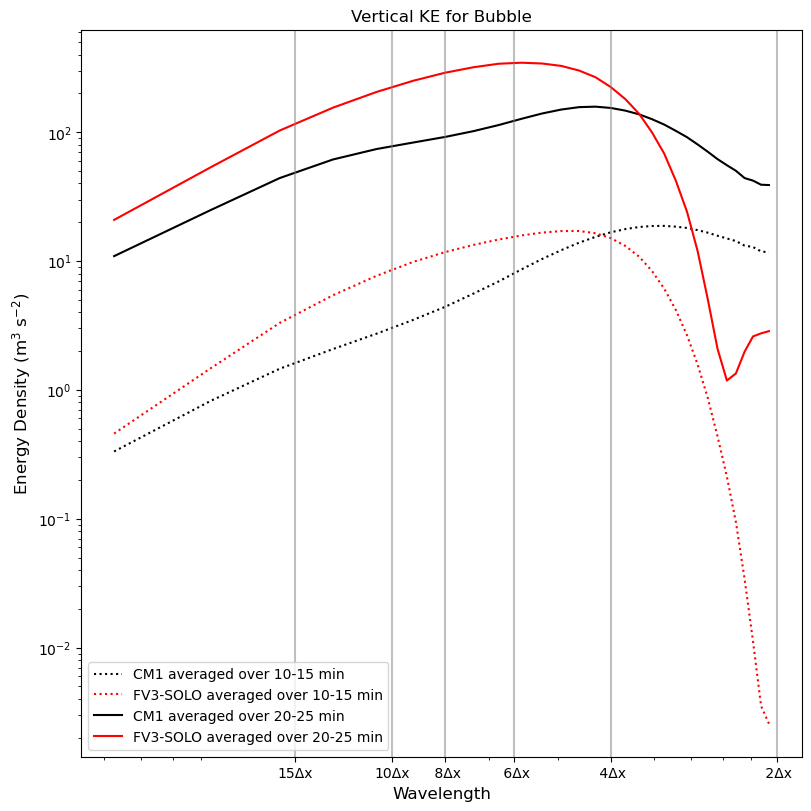

In [728]:
cm1_var  = np.zeros((nt,nx//2))
solo_var = np.zeros((nt,nx//2))

nt     = 21
nstart = 10

_sep1 = ' ' * 10

for n, tlevel in enumerate(nstart+np.arange(nt)):

    flat_max_index = np.argmax( cm1['w'][tlevel,  :,:, nx2] )
    k_index, y_index = np.unravel_index(flat_max_index, cm1['w'][tlevel, :, :, nx2].shape)
    # print(f"The CM1 maximum value is at k: {k_index}, y: {y_index}")
    cm1_max_row = cm1['w'][tlevel, k_index , :, :]

    flat_max_index = np.argmax( solo['w'][tlevel-1,  :, :, nx2] )
    k_index, y_index = np.unravel_index(flat_max_index, cm1['w'][tlevel, :, :, ny2].shape)
    # print(f"The SOLO maximum value is at k: {k_index}, y: {y_index}")
    solo_max_row = solo['w'][tlevel-1, k_index , :, :]

    kvals, cm1_var[n,:],  wavenumber = py_spectra.get_spectra2D_DCT(cm1_max_row, dx=1., dy=1., varray = None, sep=_sep1)
    kvals, solo_var[n,:], wavenumber = py_spectra.get_spectra2D_DCT(solo_max_row, dx=1., dy=1., varray = None, sep=_sep1)

#---------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(8,8))

for n in [0,2]:

    m = n*5

    ax.loglog(wavenumber[1:-1], cm1_var[m:m+6].mean(axis=0)[1:-1], color='k', linestyle=linestyles[n], label=f'CM1 averaged over {m+10}-{m+15} min')
    ax.loglog(wavenumber[1:-1], solo_var[m:m+6].mean(axis=0)[1:-1], color='r', linestyle=linestyles[n], label=f'FV3-SOLO averaged over {m+10}-{m+15} min')

print(wavenumber[:-1])

ax.legend(fontsize=10, loc='lower left')

# Label x-axis

xlabels    = [f'{x:2d}\u0394x' for x in [2, 4, 6, 8, 10, 15]]
label_xlim = [2.0/x for x in [2, 4, 6, 8, 10, 15]]
    
ax.set_xticks(label_xlim, xlabels)

for n, w in enumerate([2.0, 4.0, 6.0, 8.0, 10., 15.]):
    ax.axvline(x = 2.0/w, color = 'grey', alpha=0.5)  

ax.set_ylabel(r"Energy Density (m$^3$ s$^{-2}$)", fontsize=12);
ax.set_xlabel(r"Wavelength", fontsize=12);
ax.set_title('Vertical KE for Bubble');

plt.savefig("./Figures/Vertical_KE_Spectra_3km.pdf")

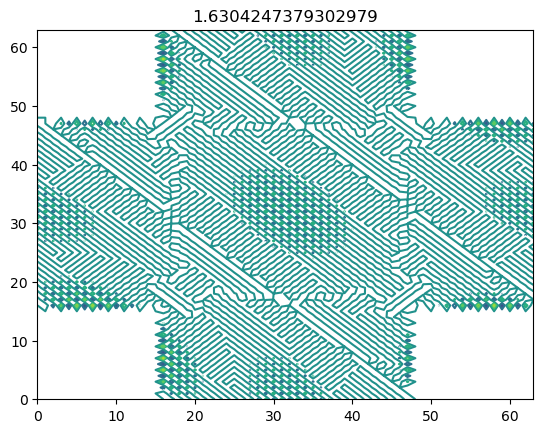

Text(0.5, 1.0, '1.6440587043762207')

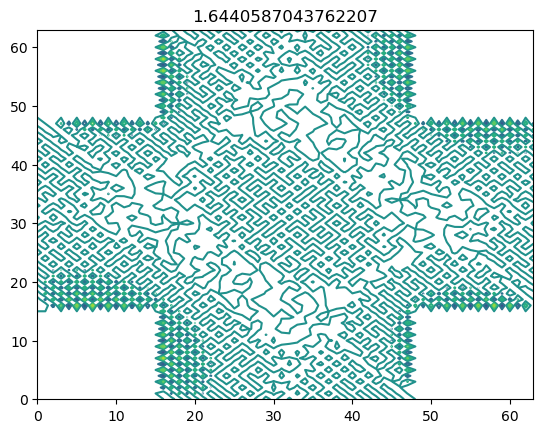

In [735]:
# FFT mositure fluxes
from scipy import fftpack

def compute_2D_spectrum(array, keep_fraction=0.5):

    im1  = fftpack.fft2(array)
    
    r, c = im1.shape

    if keep_fraction > 0.5:

        keep = 1.0 - keep_fraction

    else:

        keep = keep_fraction

    im2 = im1.copy()
    
    im2[int(r*keep):int(r*(1-keep))]   = 0.0
    im2[:,int(c*keep):int(c*(1-keep))] = 0.0

    if keep_fraction > 0.5:

        im3 = np.where(np.abs(im2) > 0.0, 0.0, im1)

        return fftpack.ifft2(im3).real, im3

    else:

        return fftpack.ifft2(im2).real, im2


########################################################################

nt       = cm1['rw'].shape[0]
nz       = len(zlevels)
nx       = xc.shape[0]
ny       = yc.shape[0]
cm1_filt  = np.zeros((nt,nz,ny,nx))
solo_filt = np.zeros((nt-1,nz,ny,nx))
cm1_spec  = np.zeros((nt,nz,ny,nx))
solo_spec = np.zeros((nt-1,nz,ny,nx))


keep_fraction = 0.75

for tlevel in np.arange(nt):

    for k in np.arange(nz):

        cm1_filt[tlevel,k], cm1_spec[tlevel,k] = compute_2D_spectrum(cm1['rw'][tlevel, k , :, :], keep_fraction=keep_fraction)

        if tlevel < nt-1:

            solo_filt[tlevel,k], solo_spec[tlevel,k] = compute_2D_spectrum(solo['rw'][tlevel, k , :, :], keep_fraction=keep_fraction)


plt.contour(cm1_spec[10,10,:,:]);
plt.title(f"{np.abs(cm1_spec[10,10,:,:]).max()}")
plt.show()
plt.contour(solo_spec[9,10,:,:]);
plt.title(f"{np.abs(solo_spec[9,10,:,:]).max()}")

(60, 200) (60, 200)


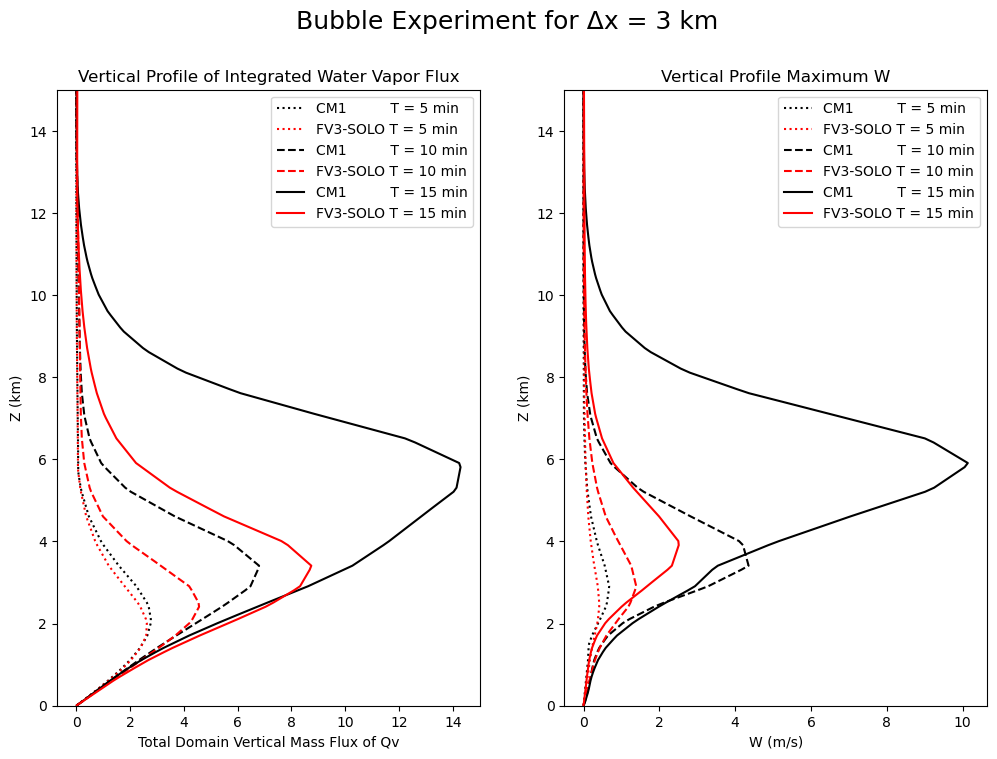

In [736]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']
yc    = cm1['yc']

# cm1_rwq_profile = cm1['rw'][1:].sum(axis=(2,3)) 
# solo_rwq_profile = solo['rw'].sum(axis=(2,3))  

# cm1_filt_profile  = cm1_filt[1:].sum(axis=(2,3))
# solo_filt_profile = solo_filt.sum(axis=(2,3))

cm1_rwq_profile = cm1['rw'][1:].max(axis=(2,3)) 
solo_rwq_profile = solo['rw'].max(axis=(2,3))  

cm1_filt_profile  = cm1_filt[1:].max(axis=(2,3))
solo_filt_profile = solo_filt.max(axis=(2,3))


print(solo_rwq_profile.shape, solo_filt_profile.shape)

linestyles = [':', '--', 'solid', 'dashdot', ':'] 

fig, ax = plt.subplots(1,2, figsize=(12,8))

for n, t in enumerate([5, 10, 15]):

    ax[0].plot(cm1_rwq_profile[t], zlevels/1000., color='k', linestyle=linestyles[n],     label=f'CM1          T = {t} min')
    ax[0].plot(solo_rwq_profile[t], zlevels/1000., color='r', linestyle=linestyles[n],    label=f'FV3-SOLO T = {t} min')

    ax[1].plot(cm1_filt_profile[t], zlevels/1000., color='k', linestyle=linestyles[n],    label=f'CM1          T = {t} min')
    ax[1].plot(solo_filt_profile[t], zlevels/1000., color='r', linestyle=linestyles[n], label=f'FV3-SOLO T = {t} min')
    
    # solo_mass_flux = np.where(solo['rw'][t] > 2.5, solo['rw'][t], 0.0)
    # ax[1].plot(solo_mass_flux.sum(axis=(1,2)), zlevels/1000., color='r', linestyle=linestyles[n], label=f'FV3-SOLO T = {t} min')


ax[0].set_xlabel('Total Domain Vertical Mass Flux of Qv');
ax[0].set_ylabel('Z (km)');
ax[0].legend();
ax[0].set_title('Vertical Profile of Integrated Water Vapor Flux');

ax[1].set_xlabel('W (m/s)');
ax[1].set_ylabel('Z (km)');
ax[1].legend();
ax[1].set_title('Vertical Profile Maximum W');

ax[0].set_ylim(0,15.)
ax[1].set_ylim(0,15.)

plt.suptitle("Bubble Experiment for \u0394x = 3 km", fontsize=18)

plt.savefig("./Figures/Vertical_Water_Vapor_3km.pdf")


4416.91669402644 5017.087890625
48826.66468620302 52029.23046875
92718.08154881 97666.3125
136705.9824988246 142812.625
180360.13282835484 187602.3125
223455.50358295444 232349.171875
266154.6617746353 277064.8125
309657.91270136833 321231.375
353634.33882594114 365058.4375
393733.162432909 406770.78125
429164.40591216093 445744.8125
464459.56081151974 484667.9375
496534.1538190843 520875.5625
528608.7803542614 557083.125
558344.7553217411 592112.0
581870.8464503288 623685.75
605396.9711065294 655259.5
627079.077064991 685745.6875
635559.7525835038 708073.6875
644040.4951572419 730401.625
652521.2377309799 752729.5625
648787.871003151 766897.875
635129.5933127403 775065.4375
621471.2485671045 783233.0
607812.970876694 791400.375
584483.5862517357 789362.5
552294.1946983339 780247.8125
520104.8031449318 771133.375
487915.41159152996 762018.875
455726.02003812796 749980.4375
415477.3615300656 714518.25
375123.9962875844 679055.9375
334770.63104510313 643593.6875
294417.23227500916 608131

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


314433.88760089874 141442.859375
295292.93999075895 131112.46875
276152.0091444254 121070.109375
257011.0782980919 112957.25
239457.51227438453 104844.40625
224515.1270180941 96731.546875
209572.72499799728 88618.6796875
194630.3397417069 82026.140625
179687.9377216101 75819.1796875
167370.41249871254 69612.21875
155469.43433582786 63405.2421875
143568.4394091368 58053.41015625
131667.4528643489 53375.1484375
120949.43784177306 48696.8828125
111686.2613707781 44018.6171875
102423.08489978313 39999.5390625
93159.9084287882 36534.54296875
84610.72761565448 33069.53515625
77988.53795975447 29604.53515625
71366.34830385447 26792.359375
64744.154457002885 24289.6953125
58545.94241827728 21787.03125
53571.03981077671 19284.3671875
48596.133012324586 17269.388671875
43621.22621387243 15552.162109375
38740.117102861404 13834.9365234375
35449.68366622925 12117.712890625
32159.246038645506 10609.69921875
28868.812602013353 9503.205078125
25578.377069905404 8396.712890625
23014.797130599618 7290.

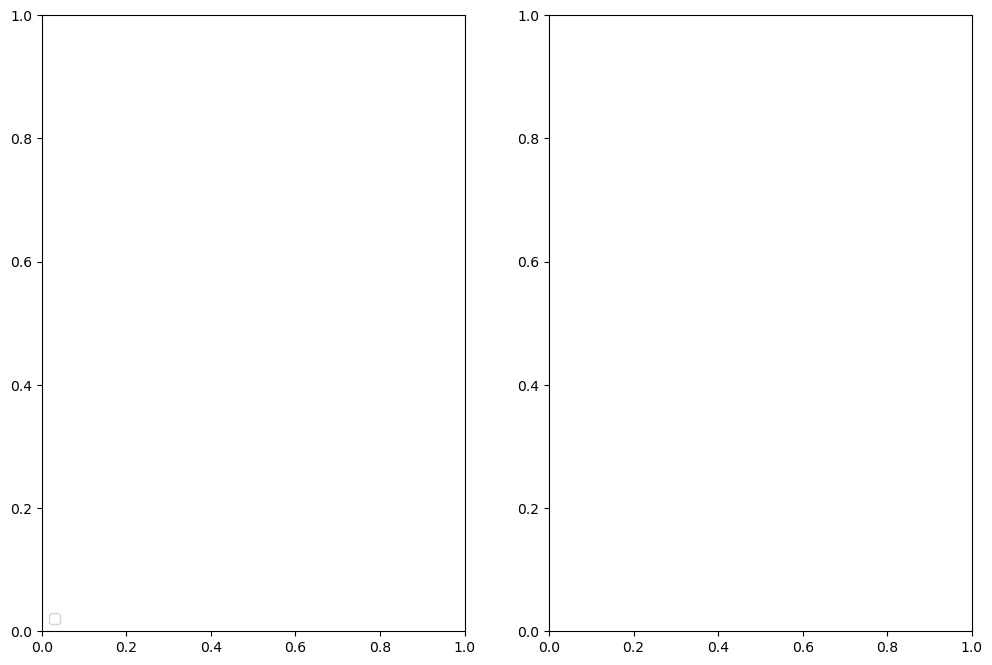

In [460]:
from scipy import fftpack

nz       = len(zlevels)
nx       = xc.shape[0]
ny       = yc.shape[0]
cm1_var  = np.zeros((nt,nz,ny,nx))
solo_var = np.zeros((nt,nz,ny,nx))

nt     = 21
nstart = 10

linestyles = ['solid', '--', 'solid', 'dashdot', ':']

_sep1 = ' ' * 10

fig, ax = plt.subplots(1,2, figsize=(12,8))

keep_fraction = 0.5

for n, tlevel in enumerate(nstart+np.arange(nt)):

    for k in np.arange(nz):

        cm1_max_row = cm1['rwqv'][tlevel, k , :, :] * (3000.**2)
        im2         = fftpack.fft2(cm1_max_row)
        
        r, c = im2.shape

        im2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0.0
        im2[:,int(c*keep_fraction):int(c*(1-keep_fraction))] = 0.0
        cm1_var[n,k] = fftpack.ifft2(im2).real
        
        solo_max_row  = solo['rwqv'][tlevel-1, k , :, :] * (3000**2)
        im2           = fftpack.fft2(solo_max_row)
        r, c = im2.shape

        im2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0.0
        im2[:,int(c*keep_fraction):int(c*(1-keep_fraction))] = 0.0
        solo_var[n,k] = fftpack.ifft2(im2).real

        print(solo_var[n,k].max(), cm1_var[n,k].max())
        
# m = -1

# print(cm1_var[n,k].shape)

# for n in [10,20]:

#     m +=1

#     k = 20

#     ax[0].loglog(wavenumber[1:-1], cm1_var[n,k][1:-1],  color='k', linestyle=linestyles[m], label=f'CM1 averaged over {m+10}-{m+15} min')
#     ax[0].loglog(wavenumber[1:-1], solo_var[n,k][1:-1], color='r', linestyle=linestyles[m], label=f'FV3-SOLO averaged over {m+10}-{m+15} min')

# print(wavenumber[:-1])

ax[0].legend(fontsize=10, loc='lower left')

# Label x-axis

# xlabels    = [f'{x:2d}\u0394x' for x in [2, 4, 6, 8, 10, 15]]
# label_xlim = [2.0/x for x in [2, 4, 6, 8, 10, 15]]
    
# ax.set_xticks(label_xlim, xlabels)

# for n, w in enumerate([2.0, 4.0, 6.0, 8.0, 10., 15.]):
#     ax.axvline(x = 2.0/w, color = 'grey', alpha=0.5)  

# ax.set_ylabel(r"Energy Density (m$^3$ s$^{-2}$)", fontsize=12);
# ax.set_xlabel(r"Wavelength", fontsize=12);
# ax.set_title('Vertical KE for Bubble');



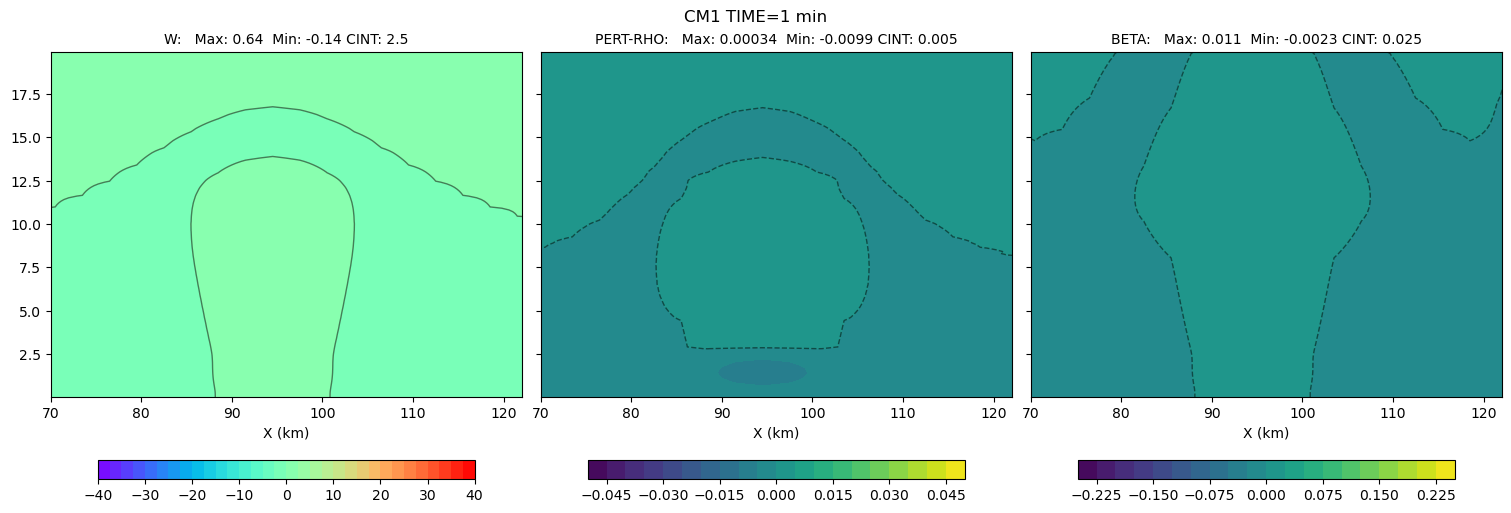

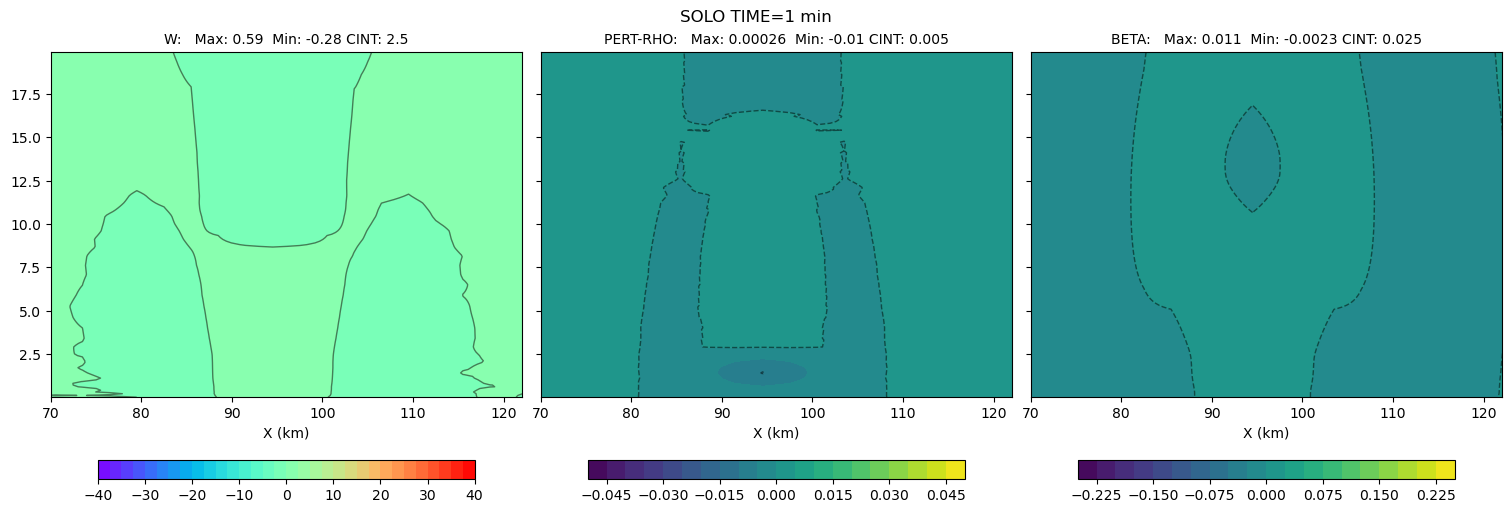

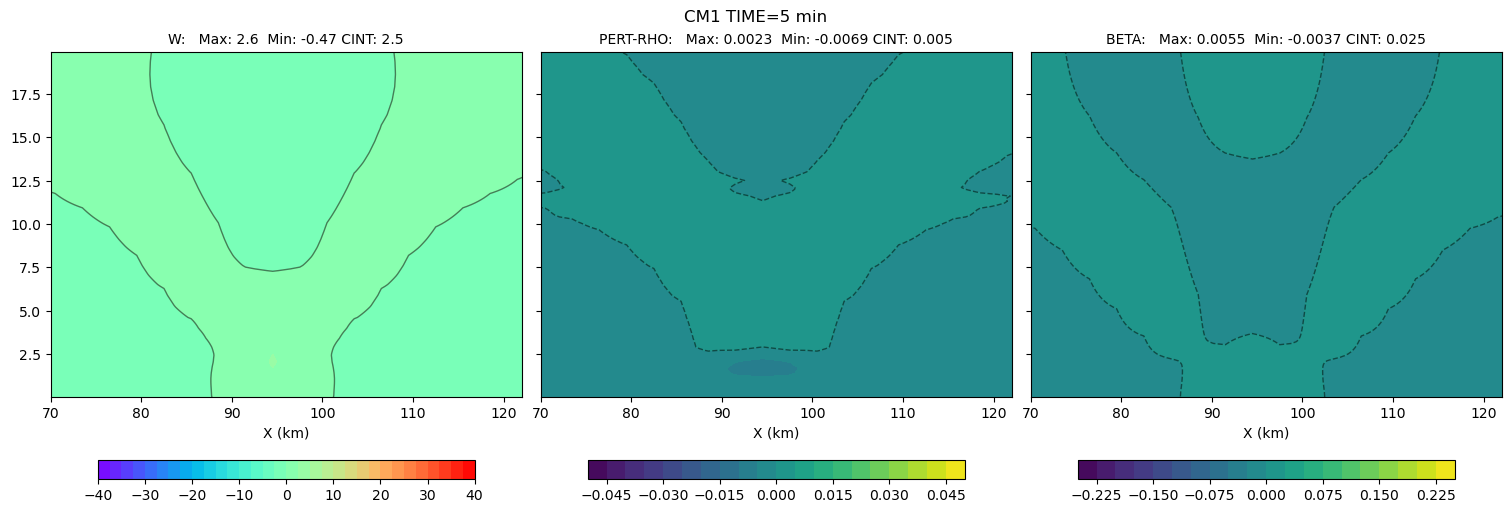

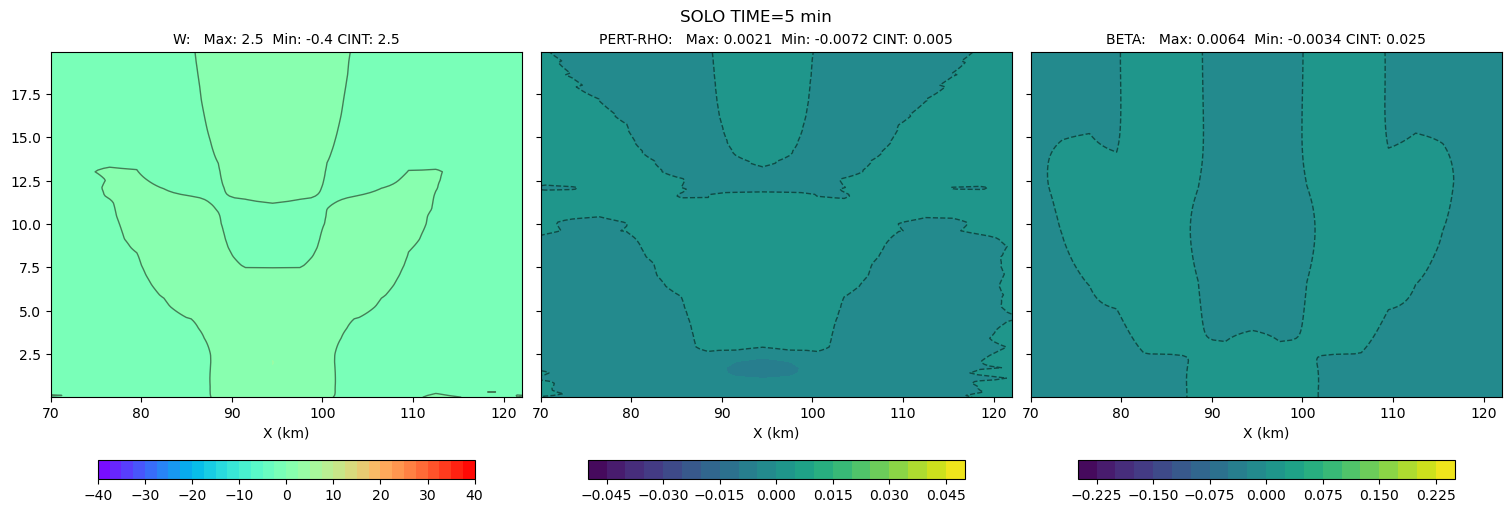

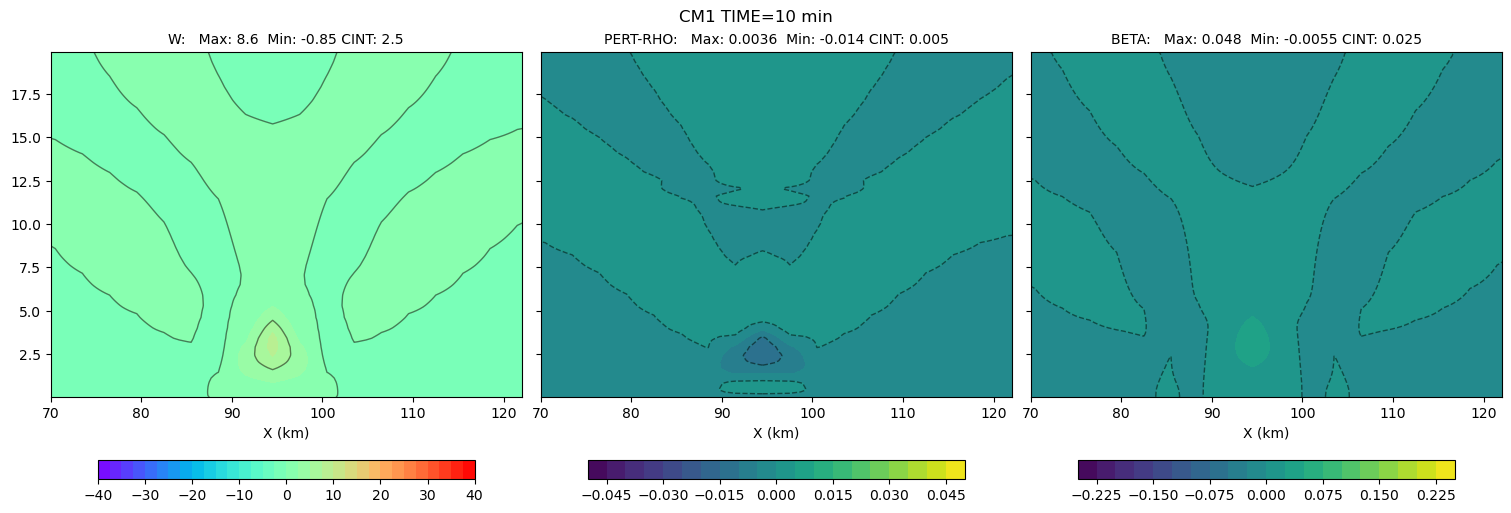

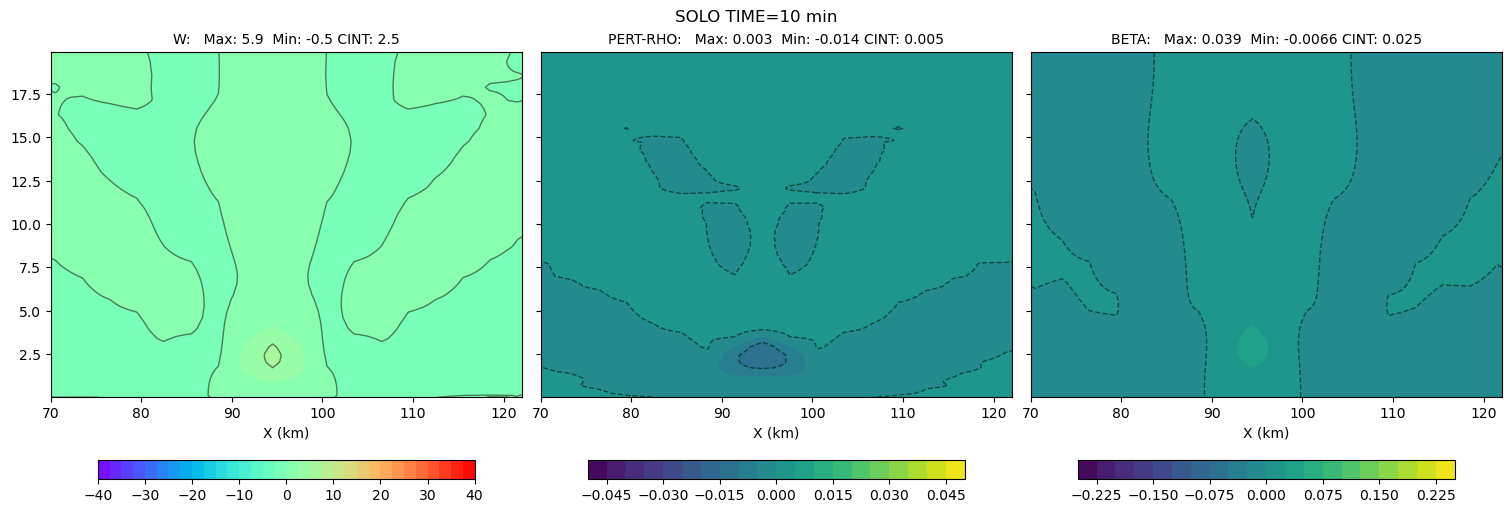

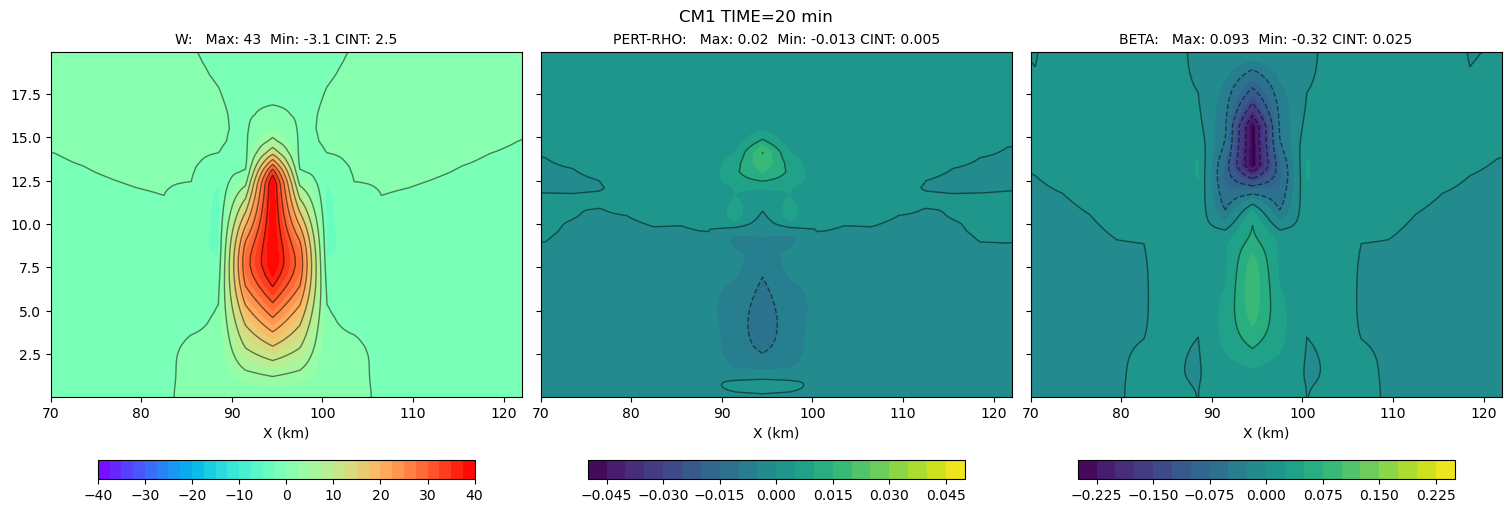

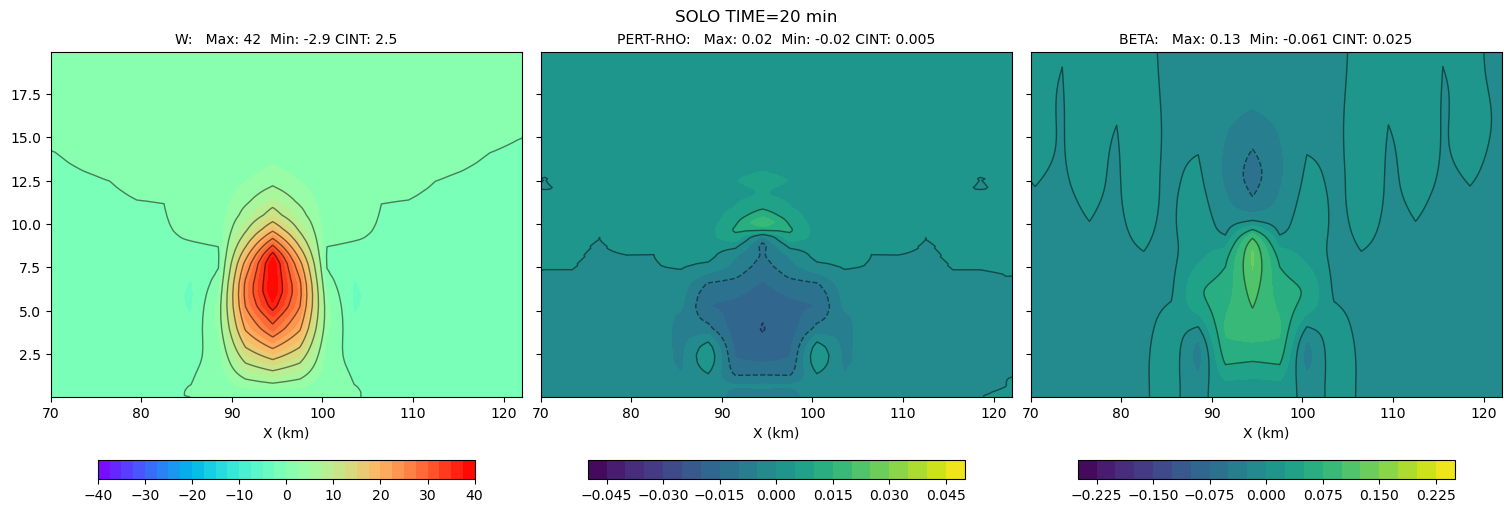

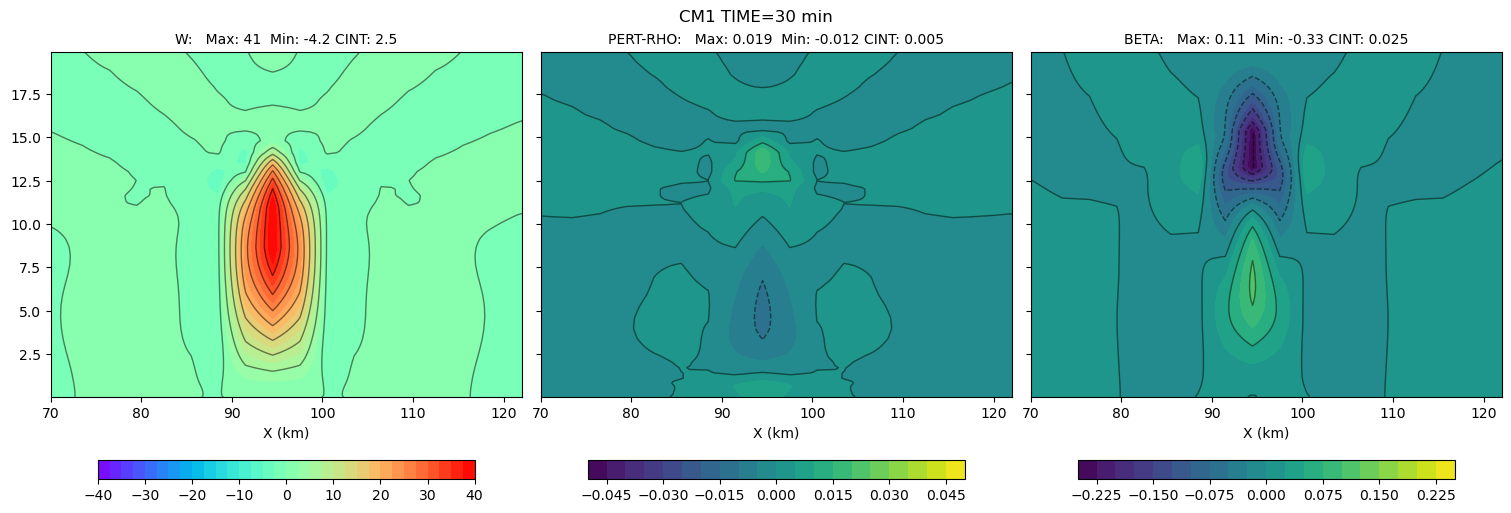

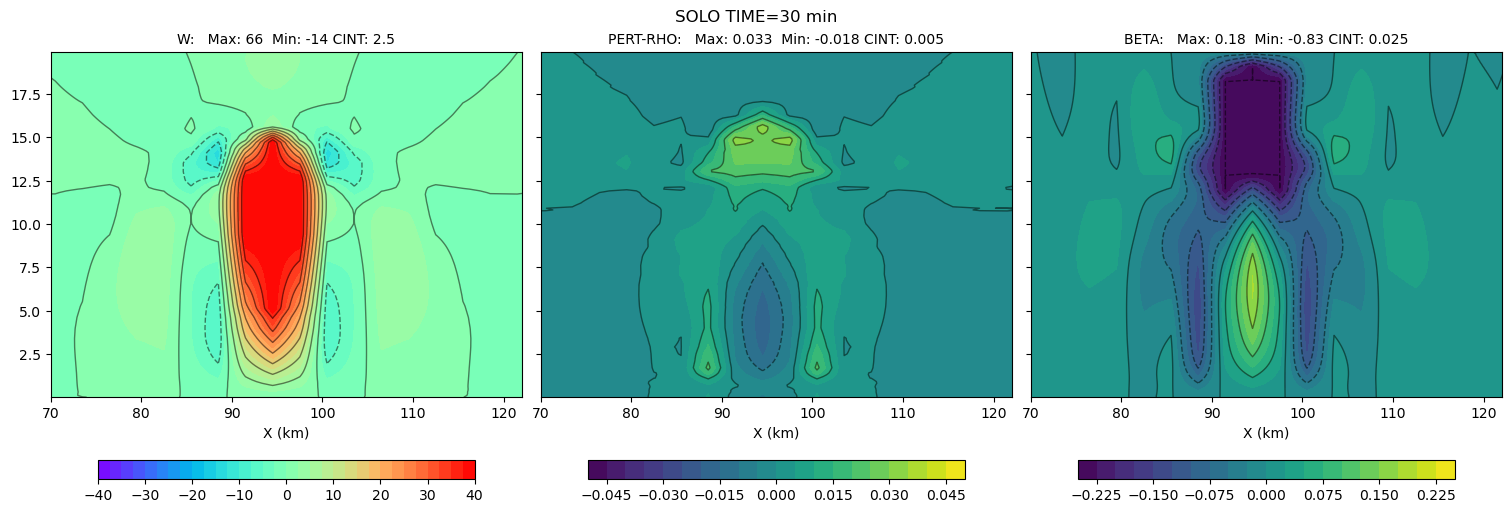

In [213]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

nx2 = (xc.shape[0]//2) - 1
ny2 = (yc.shape[0]//2) - 1

clevs = list(-3. + 0.25*np.arange(25))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

ny2 = (xc.shape[0]//2) - 1

wcint   = [-40.,40.,2.5]
rcint   = [-0.05, 0.05, 0.005]
bcint   = [-0.25, 0.25, 0.025]
c_focus = None

for tlevel in [1, 5, 10, 20, 30]:

    fields = []
    fields.append(container( cm1['w'][tlevel,  :,:,ny2],     yc, zlevels/1000.,    limit_fld=True, c_focus=c_focus,    cint=wcint, cmap=plt.cm.rainbow))
    fields.append(container( cm1['rho_p'][tlevel,  :,:,ny2], yc, zlevels/1000.,                  cint=rcint, cmap=plt.cm.viridis))
    fields.append(container( cm1['beta'][tlevel,  :,:,ny2],  yc, zlevels/1000.,                  cint=bcint, cmap=plt.cm.viridis))
    plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"CM1 TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.], sharey=True);

    fields = []
    fields.append(container(solo['w'][tlevel-1,:,:,ny2], yc, zlevels/1000.,         limit_fld=True,  cint=wcint, cmap=plt.cm.rainbow))
    fields.append(container(solo['rho_p'][tlevel-1,:,:,ny2], yc, zlevels/1000.,                  cint=rcint, cmap=plt.cm.viridis))
    fields.append(container(solo['beta'][tlevel-1,:,:,ny2], yc, zlevels/1000.,                   cint=bcint, cmap=plt.cm.viridis)) 
    plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"SOLO TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.],
                     sharey=True);

    # fields = []
    # fields.append(container(div['w'][tlevel-1,:,:,ny2], yc, zlevels/1000.,     cint=wcint, cmap=plt.cm.rainbow))
    # fields.append(container(div['rho_p'][tlevel-1,:,:,ny2], yc, zlevels/1000., cint=rcint, cmap=plt.cm.viridis))
    # fields.append(container(div['beta'][tlevel-1,:,:,ny2], yc, zlevels/1000.,  cint=bcint, cmap=plt.cm.viridis))
    
    # plot_contour_row(fields, ptitle=['W', 'PERT-RHO', 'BETA'], suptitle=f"S-DIV TIME={tlevel} min", xlabel='X (km)', ylabel='Z (km)', xlim=[70.,122.],
    #                  sharey=True);


#plt.savefig(f"XZ_3km.png")

    # klevel = 10
    
    # fields = []
    # fields.append(container( cm1['beta'][tlevel,   klevel, :, :], yc, xc))
    # fields.append(container(solo['beta'][tlevel-1, klevel, :, :], yc, xc))
    # plot_contour_row(fields, ptitle=['CM1', 'SOLO'], suptitle=f"BUBBLE TIME={tlevel} min", xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.01);

# plt.savefig(f"Initial_Condition_XY_K10_3km.png")

# fields = []
# fields.append(container(cm1['pert_th'][0,:,96:160,23]-solo['theta_IC'][:,96:160,23], xc[96:160], zlevels/1000.))
# plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Z (km)',  cmap=plt.cm.rainbow, cint=0.001)


# fields = []
# fields.append(container(cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64], xc[96:160], yc[0:64]))
# plot_contour_row(fields, ptitle=['DIFF'], title='BUBBLE', xlabel='X (km)', ylabel='Y (km)', cmap=plt.cm.rainbow, cint=0.001);

# print((cm1['pert_th'][0,klevel,96:160,0:64]-solo['theta_IC'][klevel,96:160,0:64]).min())